# Ch8 - The UNIX System Interface

The UNIX OS provides its services through a set of system calls, which are in effect functions within the OS that may be called by user programs.

This chapter describes how to use some of the most important systems calls from C programs
- sometimes necessary to use system calls for max efficiency, or to access some facility that's not available in the library

will show the UNIX sys calls for IO & how parts of the stdlib can be implemented with them

## 8.1 File Descriptors
In the UNIX OS all IO is done by reading or writing files bc all peripheral devices, even keyboard & screen, are files in the file system
- this means that a single homogenous interface handles all communication between a program & peripheral devices

In the most general case before you read a file you must inform your system of your intent to do so - process called *opening* the file

The system checks your right to read/write a file, if all is well it returns to the program a small non-negative integer called a **file descriptor**
- whenever input or output is to be done on the file, the file descriptor is used instead of the name to identify the file
- all info about an open file is maintained by the system; the user program refers to the file only by the file descriptor

since input & output involving screen & keyboard is so common, special arrangements exist to make this convenient. 
- when the shell (command interpreter) runs a file, 3 files are open with file descriptors 0, 1, and 2, called the standard input, standard output and the standard error.
- if a program reads 0 and writes 1 & 2 it can do input & output w/o worrying about opening files

the program does not know where its input comes from nor where its output goes so long as it uses file 0 for input and 1 and 2 for output

## 8.2 Low Level I/O - Read and Write
Input & output uses the read & write system calls, which are accessed from C programs called `read` and `write`
- for both the first argument is a file descriptor
- the second argument is a character array of where the data is to go or come from
- third - the number of bytes to be transferred

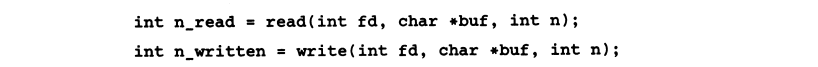

each call returns a count of the number of bytes transferred
- any number of bytes can be read or written in one call
    - the most common are 1, which means 1 byte at a time ("unbuffered"), and a number like 1024 or 4069 that corresponds to a physical block size on a peripheral device
- larger sizes will be more efficient bc fewer system calls will be made

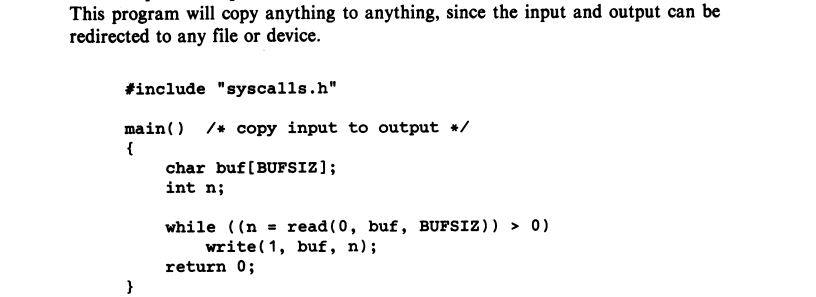

note: `syscalls.h` is not standard

## 8.3 Open, Creat, Close, Unlink
Other than the default standard input, output and error, you must explicitly open files in order to read or write them

there are 2 system calls for this; `open` and creat`
- `open` is just like fopen, but returns a file dexcriptor instead of returning a file pointer
    - returns -1 if an error occurs
- `creat` is provided to create new files or rewrite old ones

## 8.4 Random Access - Lseek
input & output are normally sequential, when necessary however a file can be read or written in any arbitrary order

the system call `lseek` provides a way to move around a file w/o reading or writing any data:

    long lseek(int fd, long offset, int origin);

with lseek it is possible more or less to treat files like large arrays, at the price of slower access

eg: read any number of bytes from any place in a file - it returns the number read or -1 on error

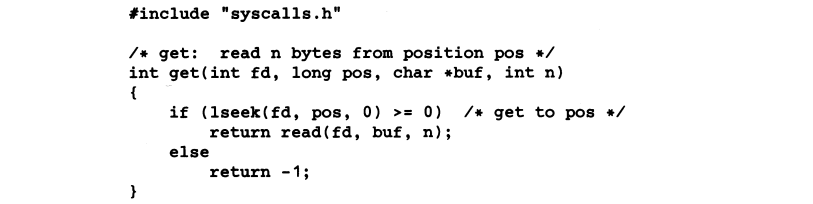

the standard lib function `fseek` is similar to lseek except that the first arg is a `FILE *` and the return is non-zero if an error occured

## 8.5 Example - An implementation of Fopen and Getc
recall files in the std lib are described by file pointers rather than file descriptors
- a file pointer is a pointer to a structure that contains several pieces of info about the file
    - a pointer to a buffer so the file can be read in large chunks
    - a count of the number of characters left in the buffer
    - the file descriptor
    - flags describing read/write mode
    - error status
    - etc

the data structure that describes a file is contained in <stdio.h>, which must be #include in any source file using the std IO lib

---

### ASIDE:
In the context of the C programming language, a **buffer** is a temporary storage area in memory used to hold data during its transfer between two places, such as between an input/output (I/O) device and the program, or between parts of a program. Buffers help to manage differences in data transfer rates, processing speeds, or data sizes between systems.

**Types of Buffers in C**
- Input Buffer: Used to temporarily store input data before it is processed. For example, when data is read from a file or the keyboard, it might first be stored in an input buffer.
- Output Buffer: Used to temporarily store data before it is sent to its destination, such as writing to a file or displaying it on the screen.
- Intermediate Buffer: Used for temporary storage in memory when data is being processed or transferred within a program.

**Common Use Cases for Buffers**
1. I/O Operations: Buffers play a key role in file and console I/O in C. 
2. Efficient I/O Handling: Standard I/O in C (via stdio.h) typically uses buffers for better performance. Functions like printf, fgets, and fputs internally use buffers to minimize the number of physical I/O operations.
3. Memory Management: Buffers are used in manual memory management when dealing with dynamic data, such as allocating memory using `malloc` or `calloc`.

**Buffer Overflow**
A buffer overflow occurs when data written to a buffer exceeds its allocated size, leading to memory corruption or vulnerabilities. This is a common security issue in C

---

## 8.6 Example - Listing Directories
different kind of file interaction - determining info about a file, not what it contains

a directory listing program such as the UNIX command `ls` is an example
- prints the names of files in a directory & optionally other info - sizes, permissions, etc

short review of UNIX file system structure:
- a directory is a file that contains a list of file names and some indication of where they're located
    - the location is an index into another table called the "inode list"
    - the inode for a file is where all info except for its name is kept
    - a directory entry generally consists of 2 items: filename & inode number
- each directory always contains entries for itself "." and its parent ".."

many programs are not "system programs"; they merely use info that is maintained by the OS

## 8.7 Example - A Storage Allocator
in this version calls to malloc & free may occur in any order; malloc calls upon the OS to obtain more memory as needed
- since other activities in the program may also request space w/o calling this allocator, the storage that malloc manages may not be contiguous
- thus its free storage is kept as a list of free blocks
- each block contains a size, a pointer to the next block, and the space itself
- the blocks are kept in order of increasing storage address, and the last block (highest address) points to the first

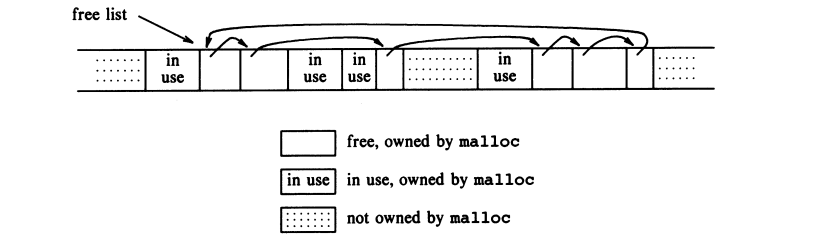

when a requiest is made, the list is scanned until a big enough block is found
- this algo is called "first-fit" in contrast t "best-fit"
- if the block is exactly the size requested, it is unlinked and returned to the user
- if the block is too big, it is split and the proper amount is returned to the user while the residue remains of the free list
- if no big enough block is found, another large chunk is obtained from the OS and linked into the free list

freeing also causes a search of the free list, to find a proper place to insert the block being freed
- if the block being freed is adjacent to a free block on either side it is coalesced with it into a single bigger block, so storage does not become to fragmented
- determining adjacency is easy bc the free list is maintained in order of increasing address

